In [38]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
except:
    print('Error loading modules')
    
    
#from metpy.cbook import get_test_data
#from metpy.io import Level3File
#from metpy.plots import add_metpy_logo, add_timestamp, colortables

In [39]:
#try:
import metpy.calc as mpcalc
import metpy.constants as mpconst
from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.io import metar, Level3File
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot, add_timestamp, colortables

from siphon.catalog import TDSCatalog
from datetime import datetime
import xarray as xr
from metpy.units import units
from siphon.radarserver import RadarServer
from datetime import datetime,timedelta
    
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from siphon.cdmr import Dataset
    
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES,ctables
    
    
#except:
#    print('Error loading modules')
    
    
%matplotlib inline

now=datetime.utcnow()


#Product codes
# NCR   Composite Refl (37)
#
# N0B - Super Res Base Refl  (153)
# N0C - Super Res CC   (161)
# N0S - Storm Rel Mean Vel (56)
# NST - SCIT (58)
# N0X - ZDR (15)
# N0G - Base Radial Vel (1 54)

product_codes = ['N0B']
#data_dir='/export/home/orpg9/wxdata/level_III/TLX'
data_dir='/home/pmccrone/data/NEXRAD/levelIII/KTLX'

#Level3_TLX_N0B_20220505_1529.nids  Level3_TLX_N0B_20220505_1541.nids
#Level3_TLX_N0B_20220505_1535.nids

#Level3_TLX_N0G_20220505_1529.nids  Level3_TLX_N0G_20220505_1541.nids
#Level3_TLX_N0G_20220505_1535.nids

file=data_dir+'/Level3_TLX_N0B_20220505_1529.nids'
print('file is '+file)

file is /home/pmccrone/data/NEXRAD/levelIII/KTLX/Level3_TLX_N0B_20220505_1529.nids


In [40]:
#fig, axes = plt.subplots(1, 2, figsize=(15, 8))
#add_metpy_logo(fig, 190, 85, size='large')
#for v, ctable, ax in zip(('N0Q', 'N0U'), ('NWSReflectivity', 'NWSVelocity'), axes):
#    # Open the file
#    name = get_test_data('nids/KOUN_SDUS54_{}TLX_201305202016'.format(v), as_file_obj=False)
#    f = Level3File(name)
#
#    # Pull the data out of the file object
#    datadict = f.sym_block[0][0]
#
#    # Turn into an array, then mask
#    data = np.ma.array(datadict['data'])
#    data[data == 0] = np.ma.masked
#
#    # Grab azimuths and calculate a range based on number of gates
#    az = np.array(datadict['start_az'] + [datadict['end_az'][-1]])
#    rng = np.linspace(0, f.max_range, data.shape[-1] + 1)
#
#    # Convert az,range to x,y
#    xlocs = rng * np.sin(np.deg2rad(az[:, np.newaxis]))
#    ylocs = rng * np.cos(np.deg2rad(az[:, np.newaxis]))
#
#    # Plot the data
#    norm, cmap = colortables.get_with_steps(ctable, 16, 16)
#    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap)
#    ax.set_aspect('equal', 'datalim')
#    ax.set_xlim(-40, 20)
#    ax.set_ylim(-30, 30)
#    add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)
#
#plt.show()

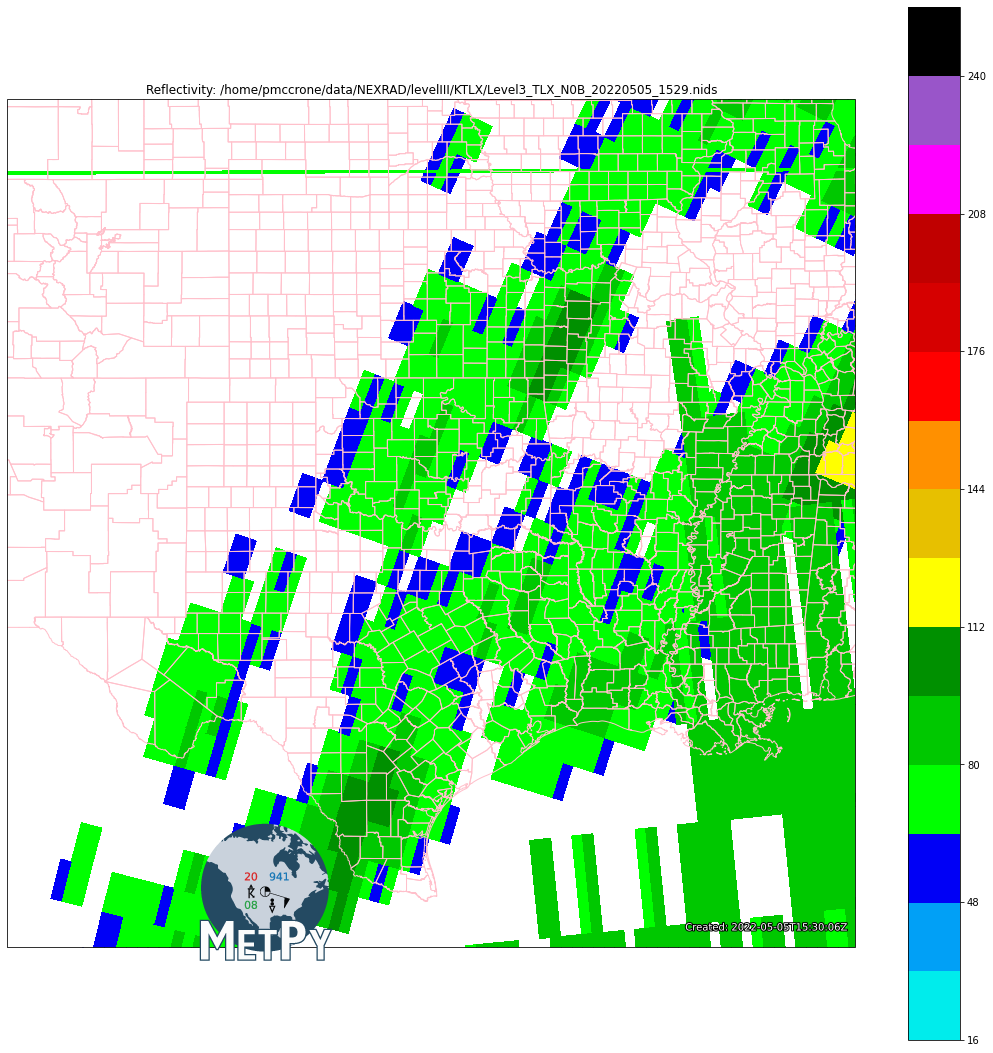

In [41]:
field_name = 'BaseReflectivityDR'
#field_name = 'CorrelationCoefficient'

#Latitude: 35.3334° (decimal), Longitude: -97.2778° (decimal), 
RadarLatitude = 35.3334

RadarLongitude= -97.2778

#proj = ccrs.LambertConformal(central_longitude=RadarLongitude,
#                                  central_latitude=RadarLatitude)

proj= ccrs.Miller()

#fig, axes = plt.subplots(1, 2, figsize=(15, 8))

#ax = plt.subplot(1, 1, 1, projection=proj)



#add_metpy_logo(fig, 190, 85, size='large')
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 16, 16)# 50

#for v, ctable, axi in zip(('N0B'), ('NWSReflectivity'), ax):
# Open the file
#name = get_test_data('nids/KOUN_SDUS54_{}TLX_201305202016'.format(v), as_file_obj=False)
#f = Level3File(name)

f = Level3File(file)

   
# Pull the data out of the file object
datadict = f.sym_block[0][0]

# Turn into an array, then mask
data = np.ma.array(datadict['data'])
data[data == 0] = np.ma.masked

#data=data/2.0#data=data-32.0

# Grab azimuths and calculate a range based on number of gates
az = np.array(datadict['start_az'] + [datadict['end_az'][-1]])
rng = np.linspace(0, f.max_range, data.shape[-1] + 1)


# Convert az,range to x,y
#xlocs = rng * np.sin(np.deg2rad(az[:, np.newaxis]))
#ylocs = rng * np.cos(np.deg2rad(az[:, np.newaxis]))
xlocs = rng * np.sin(np.deg2rad(az[:, None]))
ylocs = rng * np.cos(np.deg2rad(az[:, None]))

#This data is in km.

#x = range_data * np.sin(np.deg2rad(azimuth_data))[:,None]
#y = range_data * np.cos(np.deg2rad(azimuth_data))[:,None]

radar_data = np.ma.array(data, mask = np.isnan(data))

# Plot the data
#norm, cmap = colortables.get_with_steps(ctable, 16, 16)
fig = plt.figure(figsize=(19,19))

#ax = plt.subplot(1, 1, 1, projection=proj)
ax = plt.axes(projection=proj)

#ax.coastlines(resolution='110m',color='black')
deltadegree=4.0

img_extent = (RadarLongitude-deltadegree, RadarLongitude+deltadegree, RadarLatitude-deltadegree, RadarLatitude+deltadegree)

#ax.plot(xlocs, ylocs, c=radar_data, cmap=cmap)
#ax.imshow(radar_data, transform=proj, extent=img_extent, cmap=cmap)                          

add_metpy_logo(fig, 190, 85, size='large')


mesh=ax.pcolormesh(xlocs, ylocs, radar_data, norm=norm, cmap=cmap, zorder=0)
#ax.set_aspect('equal', 'datalim')
ax.set_ylim(RadarLatitude-deltadegree, RadarLatitude+deltadegree)
ax.set_xlim(RadarLongitude-deltadegree, RadarLongitude+deltadegree)
add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)
ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='pink')

plt.title('Reflectivity: '+file)

fig.colorbar(mesh, ax=ax)

plt.show()

In [44]:
xlocs
print('shape is')
print(xlocs.shape)
print("max   = "+str(np.max(xlocs)))
print("min   = "+str(np.min(xlocs)))
print("mean  = "+str(np.mean(xlocs)))
print("median  = "+str(np.median(xlocs)))


shape is
(721, 1841)
max   = 460.0
min   = -460.0
mean  = 0.21345359148756735
median  = 1.7145055188062946e-14


In [45]:
ylocs
print('shape is')
print(ylocs.shape)
print("max   = "+str(np.max(ylocs)))
print("min   = "+str(np.min(ylocs)))
print("mean  = "+str(np.mean(ylocs)))
print("median  = "+str(np.median(ylocs)))


shape is
(721, 1841)
max   = 460.0
min   = -460.0
mean  = -0.23706423004130595
median  = -2.5717582782094416e-14


In [35]:
ylocs.shape

(721, 1841)

In [36]:
ylocs[0,0]
ylocs[50,51]

-12.192885638528704

In [46]:
radar_data
print('shape is')
print(radar_data.shape)
print("max   = "+str(np.max(radar_data)))
print("min   = "+str(np.min(radar_data)))
print("mean  = "+str(np.mean(radar_data)))
print("median  = "+str(np.median(radar_data)))


shape is
(720, 1840)
max   = 206
min   = 21
mean  = 96.95009880464396
median  = --


/home/pmccrone/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [20]:
radar_data.shape

(720, 1840)